--- DEMO: Quick Validation Test ---
--- Running Detailed Hard Constraint Validation ---
Boundary Constraint   : ✅ PASSED 
No Overlapping        : ✅ PASSED 
Edge Placement        : ✅ PASSED 
Parallel Placement    : ✅ PASSED 
Proximity Constraint  : ✅ PASSED Actual distance: 7.81 (Limit: 10.0)
Global Balance        : ✅ PASSED CoM dist from center: 0.51 (Limit: 2.0)
Keep-Out Zone         : ✅ PASSED Path is clear

Validation elapsed time: 0.000455 seconds
✅ Demo placement is VALID (per updated checks).

--- Calculating Placement Score (Lower is Better) ---
Compactness Score (Bounding Box Area): 2050.00
Centrality Score (uC dist from center): 7.91
-------------------------------------------
Total Combined Score: 2129.06
-------------------------------------------


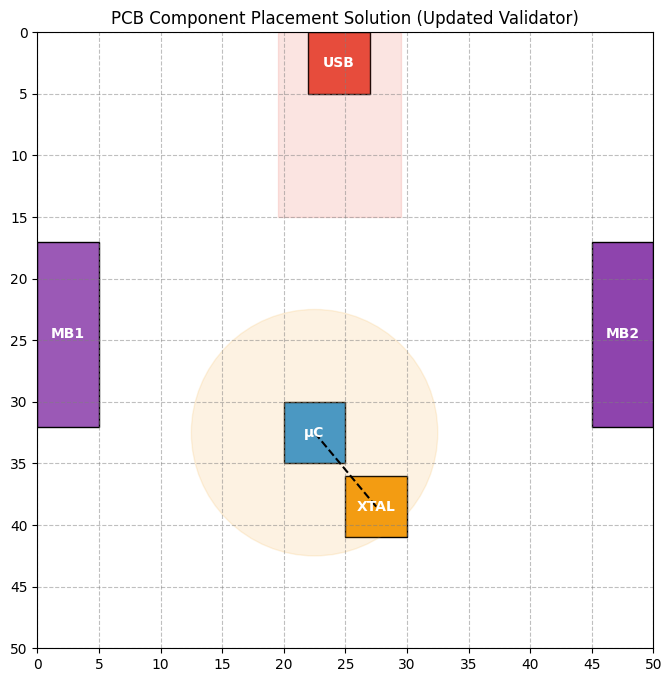

In [8]:
"""
Updated utility module for the PCB Component Placement assignment.

Improvements made:
- KEEPOUT_ZONE_DIMS corrected to (10, 15) per assignment (10 wide, 15 inward).
- Robust rectangle / segment intersection where touching counts as intersection.
- Orientation-aware parallel check for mikrobus connectors.
- Small helper functions extracted for clarity.
- Demo placement kept for quick validation (can be removed when solver is added).
"""
import time
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- Assignment Constants (Part of the problem definition) ---
BOARD_DIMS = (50, 50)
PROXIMITY_RADIUS = 10.0
CENTER_OF_MASS_RADIUS = 2.0
KEEPOUT_ZONE_DIMS = (10, 15)  # (zone_width, zone_inward_depth) -> matches assignment: 10 wide, 15 inward
VALIDATION_TIME_LIMIT = 2  # seconds (validation expected to be very fast)

# --- Geometric Helper Functions (Internal use) ---
def _get_center(comp):
    """Calculates the center coordinates of a component."""
    return (comp['x'] + comp['w'] / 2.0, comp['y'] + comp['h'] / 2.0)

def _distance(p1, p2):
    """Calculates the Euclidean distance between two points."""
    return math.hypot(p2[0] - p1[0], p2[1] - p1[1])

def _on_edge(comp):
    """Returns True if a component touches any board edge (including touching by boundary)."""
    x, y, w, h = comp['x'], comp['y'], comp['w'], comp['h']
    return (x == 0) or (y == 0) or (x + w == BOARD_DIMS[0]) or (y + h == BOARD_DIMS[1])

def _rects_overlap(r1, r2):
    """Return True if rectangles r1 and r2 overlap (touching counts as overlap).
    r is dict with x,y,w,h
    """
    # If one rectangle is to the left of the other -> no overlap
    if r1['x'] + r1['w'] <= r2['x'] or r2['x'] + r2['w'] <= r1['x']:
        return False
    # If one rectangle is above the other -> no overlap
    if r1['y'] + r1['h'] <= r2['y'] or r2['y'] + r2['h'] <= r1['y']:
        return False
    return True

# --- Robust segment-segment intersection (touching considered intersection) ---
def _orientation(a, b, c):
    """Return orientation of triplet (a,b,c): 0 colinear, 1 clockwise, 2 counterclockwise"""
    val = (b[1] - a[1]) * (c[0] - b[0]) - (b[0] - a[0]) * (c[1] - b[1])
    if abs(val) < 1e-9:
        return 0
    return 1 if val > 0 else 2

def _on_segment(a, b, c):
    """Return True if point b lies on segment ac (including endpoints)."""
    return (min(a[0], c[0]) - 1e-9 <= b[0] <= max(a[0], c[0]) + 1e-9 and
            min(a[1], c[1]) - 1e-9 <= b[1] <= max(a[1], c[1]) + 1e-9)

def _segments_intersect(a, b, c, d):
    """Return True if segment ab intersects segment cd (including touching)."""
    o1 = _orientation(a, b, c)
    o2 = _orientation(a, b, d)
    o3 = _orientation(c, d, a)
    o4 = _orientation(c, d, b)

    # General case
    if o1 != o2 and o3 != o4:
        return True
    # Special Cases - colinear & on-segment (treat as intersection)
    if o1 == 0 and _on_segment(a, c, b): return True
    if o2 == 0 and _on_segment(a, d, b): return True
    if o3 == 0 and _on_segment(c, a, d): return True
    if o4 == 0 and _on_segment(c, b, d): return True
    return False

def _segment_intersects_rect(p1, p2, rect):
    """Return True if segment p1-p2 intersects rectangle rect (including touching).
    rect: {'x','y','w','h'}
    """
    # If either endpoint is inside rect -> intersects
    rx0, ry0, rw, rh = rect['x'], rect['y'], rect['w'], rect['h']
    rx1, ry1 = rx0 + rw, ry0 + rh

    def _point_in_rect(p):
        # treat boundary as inside (touching is forbidden)
        return (rx0 - 1e-9 <= p[0] <= rx1 + 1e-9) and (ry0 - 1e-9 <= p[1] <= ry1 + 1e-9)

    if _point_in_rect(p1) or _point_in_rect(p2):
        return True

    # Check intersection with each rectangle edge
    tl = (rx0, ry0)
    tr = (rx1, ry0)
    bl = (rx0, ry1)
    br = (rx1, ry1)

    edges = [(tl, tr), (tr, br), (br, bl), (bl, tl)]
    for a, b in edges:
        if _segments_intersect(p1, p2, a, b):
            return True
    return False

# --- Public Utility Functions for Candidates ---
def validate_placement(placement, verbose=True):
    """
    Validates a component placement against all hard constraints.
    Returns True if valid, False otherwise.
    If verbose=True, prints detailed pass/fail report.
    """
    if verbose:
        print("--- Running Detailed Hard Constraint Validation ---")
    results = {}

    # Check presence
    required_keys = ['USB_CONNECTOR', 'MICROCONTROLLER', 'CRYSTAL',
                     'MIKROBUS_CONNECTOR_1', 'MIKROBUS_CONNECTOR_2']
    missing = [k for k in required_keys if k not in placement]
    if missing:
        if verbose:
            print(f"❌ FAILED: Missing components: {missing}")
        return False

    # Rule: Boundary Constraint (all within board)
    in_bounds = True
    for name, c in placement.items():
        if not (c['x'] >= 0 and c['y'] >= 0 and c['x'] + c['w'] <= BOARD_DIMS[0] and c['y'] + c['h'] <= BOARD_DIMS[1]):
            in_bounds = False
            break
    results["Boundary Constraint"] = (in_bounds, "")

    # Rule: No Overlapping (touching counts as overlap)
    overlap = False
    items = list(placement.items())
    for i in range(len(items)):
        for j in range(i + 1, len(items)):
            if _rects_overlap(items[i][1], items[j][1]):
                overlap = True
                break
        if overlap: break
    results["No Overlapping"] = (not overlap, "")

    # Rule: Edge Placement
    edge_components = ['USB_CONNECTOR', 'MIKROBUS_CONNECTOR_1', 'MIKROBUS_CONNECTOR_2']
    edge_ok = all(_on_edge(placement[name]) for name in edge_components)
    results["Edge Placement"] = (edge_ok, "")

    # Rule: Parallel Placement for mikrobus connectors
    mb1 = placement['MIKROBUS_CONNECTOR_1']
    mb2 = placement['MIKROBUS_CONNECTOR_2']

    def _is_vertical(comp): return comp['h'] > comp['w']
    def _is_horizontal(comp): return comp['w'] > comp['h']

    parallel_ok = False
    if (_is_vertical(mb1) and _is_vertical(mb2)) or (_is_horizontal(mb1) and _is_horizontal(mb2)):
        if _is_vertical(mb1):
            on_left_right = (mb1['x'] == 0 and mb2['x'] + mb2['w'] == BOARD_DIMS[0]) or (mb2['x'] == 0 and mb1['x'] + mb1['w'] == BOARD_DIMS[0])
            parallel_ok = on_left_right
        else:
            on_top_bottom = (mb1['y'] == 0 and mb2['y'] + mb2['h'] == BOARD_DIMS[1]) or (mb2['y'] == 0 and mb1['y'] + mb1['h'] == BOARD_DIMS[1])
            parallel_ok = on_top_bottom
    results["Parallel Placement"] = (parallel_ok, "")

    # Rule: Proximity
    dist = _distance(_get_center(placement['CRYSTAL']), _get_center(placement['MICROCONTROLLER']))
    results["Proximity Constraint"] = (dist <= PROXIMITY_RADIUS, f"Actual distance: {dist:.2f} (Limit: {PROXIMITY_RADIUS})")

    # Rule: Global Balance
    board_center = (BOARD_DIMS[0] / 2.0, BOARD_DIMS[1] / 2.0)
    comp_centers = [_get_center(c) for c in placement.values()]
    com_x = sum(p[0] for p in comp_centers) / len(comp_centers)
    com_y = sum(p[1] for p in comp_centers) / len(comp_centers)
    com_dist = _distance((com_x, com_y), board_center)
    results["Global Balance"] = (com_dist <= CENTER_OF_MASS_RADIUS, f"CoM dist from center: {com_dist:.2f} (Limit: {CENTER_OF_MASS_RADIUS})")

    # Rule: Keep-Out Zone
    usb = placement['USB_CONNECTOR']
    zone_w, zone_h_inward = KEEPOUT_ZONE_DIMS
    usb_cx, usb_cy = _get_center(usb)
    if usb['y'] == 0:
        zone = {'x': usb_cx - zone_w / 2.0, 'y': 0.0, 'w': zone_w, 'h': zone_h_inward}
    elif usb['y'] + usb['h'] == BOARD_DIMS[1]:
        zone = {'x': usb_cx - zone_w / 2.0, 'y': BOARD_DIMS[1] - zone_h_inward, 'w': zone_w, 'h': zone_h_inward}
    elif usb['x'] == 0:
        zone = {'x': 0.0, 'y': usb_cy - zone_w / 2.0, 'w': zone_h_inward, 'h': zone_w}
    else:
        zone = {'x': BOARD_DIMS[0] - zone_h_inward, 'y': usb_cy - zone_w / 2.0, 'w': zone_h_inward, 'h': zone_w}

    p1, p2 = _get_center(placement['CRYSTAL']), _get_center(placement['MICROCONTROLLER'])
    intersects = _segment_intersects_rect(p1, p2, zone)
    results["Keep-Out Zone"] = (not intersects, "Path is clear" if not intersects else "Path is obstructed")

    # Print only if verbose
    all_valid = True
    if verbose:
        for rule, (ok, msg) in results.items():
            status = "✅ PASSED" if ok else "❌ FAILED"
            print(f"{rule:<22}: {status} {msg}")
            if not ok:
                all_valid = False
    else:
        for ok, _ in results.values():
            if not ok:
                all_valid = False

    return all_valid

def score_placement(placement):
    """
    Calculates a score for a placement based on soft constraints.
    Lower is better. Combines bounding box area and microcontroller centrality.
    """
    print("\n--- Calculating Placement Score (Lower is Better) ---")
    min_x = min(c['x'] for c in placement.values())
    max_x = max(c['x'] + c['w'] for c in placement.values())
    min_y = min(c['y'] for c in placement.values())
    max_y = max(c['y'] + c['h'] for c in placement.values())
    bounding_box_area = (max_x - min_x) * (max_y - min_y)

    board_center = (BOARD_DIMS[0] / 2.0, BOARD_DIMS[1] / 2.0)
    micro_center = _get_center(placement['MICROCONTROLLER'])
    centrality_score = _distance(micro_center, board_center)

    total_score = bounding_box_area + (centrality_score * 10.0)  # Weight centrality
    print(f"Compactness Score (Bounding Box Area): {bounding_box_area:.2f}")
    print(f"Centrality Score (uC dist from center): {centrality_score:.2f}")
    print(f"-------------------------------------------")
    print(f"Total Combined Score: {total_score:.2f}")
    print(f"-------------------------------------------")
    return total_score

def plot_placement(placement):
    """
    Generates a matplotlib plot to visualize the component placement.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, BOARD_DIMS[0])
    ax.set_ylim(0, BOARD_DIMS[1])
    ax.set_xticks(range(0, BOARD_DIMS[0] + 1, 5))
    ax.set_yticks(range(0, BOARD_DIMS[1] + 1, 5))
    ax.grid(True, linestyle='--', color='gray', alpha=0.5)
    ax.set_aspect('equal', adjustable='box')
    ax.invert_yaxis()
    ax.set_title("PCB Component Placement Solution (Updated Validator)")

    colors = {'USB_CONNECTOR': '#e74c3c', 'MICROCONTROLLER': '#3498db', 'CRYSTAL': '#f39c12',
              'MIKROBUS_CONNECTOR_1': '#9b59b6', 'MIKROBUS_CONNECTOR_2': '#8e44ad'}
    labels = {'USB_CONNECTOR': 'USB', 'MICROCONTROLLER': 'μC', 'CRYSTAL': 'XTAL',
              'MIKROBUS_CONNECTOR_1': 'MB1', 'MIKROBUS_CONNECTOR_2': 'MB2'}

    for name, comp in placement.items():
        rect = patches.Rectangle((comp['x'], comp['y']), comp['w'], comp['h'],
                                 linewidth=1, edgecolor='black', facecolor=colors.get(name, '#999999'))
        ax.add_patch(rect)
        ax.text(comp['x'] + comp['w'] / 2.0, comp['y'] + comp['h'] / 2.0, labels.get(name, name),
                color='white', ha='center', va='center', fontweight='bold')

    uc_center = _get_center(placement['MICROCONTROLLER'])
    circle = patches.Circle(uc_center, PROXIMITY_RADIUS, fill=True, color='#f39c12', alpha=0.12)
    ax.add_patch(circle)

    usb = placement['USB_CONNECTOR']
    zone_w, zone_h_inward = KEEPOUT_ZONE_DIMS
    usb_cx, usb_cy = _get_center(usb)
    if usb['y'] == 0:
        zone_props = {'xy': (usb_cx - zone_w / 2.0, 0.0), 'w': zone_w, 'h': zone_h_inward}
    elif usb['y'] + usb['h'] == BOARD_DIMS[1]:
        zone_props = {'xy': (usb_cx - zone_w / 2.0, BOARD_DIMS[1] - zone_h_inward), 'w': zone_w, 'h': zone_h_inward}
    elif usb['x'] == 0:
        zone_props = {'xy': (0.0, usb_cy - zone_w / 2.0), 'w': zone_h_inward, 'h': zone_w}
    else:
        zone_props = {'xy': (BOARD_DIMS[0] - zone_h_inward, usb_cy - zone_w / 2.0), 'w': zone_h_inward, 'h': zone_w}

    keepout = patches.Rectangle(zone_props['xy'], zone_props['w'], zone_props['h'], fill=True, color='#e74c3c', alpha=0.15)
    ax.add_patch(keepout)

    xtal_center = _get_center(placement['CRYSTAL'])
    # draw the connection line (dashed)
    ax.plot([xtal_center[0], uc_center[0]], [xtal_center[1], uc_center[1]], 'k--')

    plt.show()

# --- Quick demo test when run as script ---
if __name__ == '__main__':
    start_time = time.perf_counter()

    print("--- DEMO: Quick Validation Test ---")
    sample_placement = {
    'USB_CONNECTOR':        {'x': 22.0, 'y': 0.0, 'w': 5.0, 'h': 5.0},   # top edge
    'MIKROBUS_CONNECTOR_1': {'x': 0.0, 'y': 17.0, 'w': 5.0, 'h': 15.0}, # left edge (vertical)
    'MIKROBUS_CONNECTOR_2': {'x': 45.0, 'y': 17.0, 'w': 5.0, 'h': 15.0},# right edge (vertical)
    'MICROCONTROLLER':      {'x': 20.0, 'y': 30.0, 'w': 5.0, 'h': 5.0}, # shifted downward
    'CRYSTAL':              {'x': 25.0, 'y': 36.0, 'w': 5.0, 'h': 5.0}, # near micro
    }

    ok = validate_placement(sample_placement)
    elapsed = time.perf_counter() - start_time
    print(f"\nValidation elapsed time: {elapsed:.6f} seconds")
    if ok:
        print("✅ Demo placement is VALID (per updated checks).")
    else:
        print("❌ Demo placement is INVALID (per updated checks).")
    # Score & plot for visual inspection
    score_placement(sample_placement)
    plot_placement(sample_placement)


def basic_solver_with_output():
    """
    Basic solver:
    - Fixes USB + MikroBus deterministically
    - Explores microcontroller positions in a small search grid around center
    - Places crystal near microcontroller (within PROXIMITY_RADIUS)
    - Returns the first valid placement found
    - Automatically validates, scores, and plots the result
    """
    USB = (5, 5); MICRO = (5, 5); CRYSTAL = (5, 5); MIKROBUS = (5, 15)
    board_w, board_h = BOARD_DIMS

    # deterministic edge placement
    mb1 = {'x': 0.0, 'y': 17.0, 'w': float(MIKROBUS[0]), 'h': float(MIKROBUS[1])}
    mb2 = {'x': float(board_w - MIKROBUS[0]), 'y': 17.0, 'w': float(MIKROBUS[0]), 'h': float(MIKROBUS[1])}
    usb_x = math.floor((board_w - USB[0]) / 2.0)
    usb = {'x': float(usb_x), 'y': 0.0, 'w': float(USB[0]), 'h': float(USB[1])}

    start = time.perf_counter()
    center_x = (board_w - MICRO[0]) // 2
    center_y = (board_h - MICRO[1]) // 2

    # explore small search grid for microcontroller
    for dx in range(-10, 11):
        for dy in range(-10, 11):
            micro_x = center_x + dx
            micro_y = center_y + dy
            micro = {'x': float(micro_x), 'y': float(micro_y), 'w': float(MICRO[0]), 'h': float(MICRO[1])}

            uc_center = _get_center(micro)

            # explore possible crystal placements around micro
            step = 1
            for i in range(-int(PROXIMITY_RADIUS), int(PROXIMITY_RADIUS) + 1, step):
                for j in range(-int(PROXIMITY_RADIUS), int(PROXIMITY_RADIUS) + 1, step):
                    cx_center = uc_center[0] + i
                    cy_center = uc_center[1] + j
                    if _distance((cx_center, cy_center), uc_center) > PROXIMITY_RADIUS:
                        continue

                    # crystal placement (aligned to integer grid)
                    cw, ch = CRYSTAL
                    cx_tl = round(cx_center - cw / 2.0)
                    cy_tl = round(cy_center - ch / 2.0)
                    crystal = {'x': float(cx_tl), 'y': float(cy_tl), 'w': float(cw), 'h': float(ch)}

                    placement = {
                        'USB_CONNECTOR': usb,
                        'MIKROBUS_CONNECTOR_1': mb1,
                        'MIKROBUS_CONNECTOR_2': mb2,
                        'MICROCONTROLLER': micro,
                        'CRYSTAL': crystal
                    }

                    # validate
                    if validate_placement(placement, verbose=False):
                        elapsed = time.perf_counter() - start
                        print(f"\n✔ Found valid placement in {elapsed:.3f}s")
                        print("Placement dictionary:")
                        for k, v in placement.items():
                            print(f"{k}: {v}")

                        # score and plot
                        score_placement(placement)
                        plot_placement(placement)
                        return placement

    print("\n❌ No valid placement found")
    return None

def optimizer(time_budget=2.0):
    """
    Optimizer version of the solver:
    - Tries many microcontroller + crystal positions
    - Validates placements
    - Scores valid ones
    - Keeps track of the best (lowest score)
    - Stops after time_budget seconds
    """
    USB = (5, 5); MICRO = (5, 5); CRYSTAL = (5, 5); MIKROBUS = (5, 15)
    board_w, board_h = BOARD_DIMS

    # deterministic edge placement
    mb1 = {'x': 0.0, 'y': 17.0, 'w': float(MIKROBUS[0]), 'h': float(MIKROBUS[1])}
    mb2 = {'x': float(board_w - MIKROBUS[0]), 'y': 17.0, 'w': float(MIKROBUS[0]), 'h': float(MIKROBUS[1])}
    usb_x = math.floor((board_w - USB[0]) / 2.0)
    usb = {'x': float(usb_x), 'y': 0.0, 'w': float(USB[0]), 'h': float(USB[1])}

    best = None
    best_score = float("inf")
    start = time.perf_counter()
    checked = 0

    center_x = (board_w - MICRO[0]) // 2
    center_y = (board_h - MICRO[1]) // 2

    for dx in range(-10, 11):
        for dy in range(-10, 11):
            micro_x = center_x + dx
            micro_y = center_y + dy
            micro = {'x': float(micro_x), 'y': float(micro_y), 'w': float(MICRO[0]), 'h': float(MICRO[1])}

            uc_center = _get_center(micro)

            step = 1
            for i in range(-int(PROXIMITY_RADIUS), int(PROXIMITY_RADIUS) + 1, step):
                for j in range(-int(PROXIMITY_RADIUS), int(PROXIMITY_RADIUS) + 1, step):
                    cx_center = uc_center[0] + i
                    cy_center = uc_center[1] + j
                    if _distance((cx_center, cy_center), uc_center) > PROXIMITY_RADIUS:
                        continue

                    cw, ch = CRYSTAL
                    cx_tl = round(cx_center - cw / 2.0)
                    cy_tl = round(cy_center - ch / 2.0)
                    crystal = {'x': float(cx_tl), 'y': float(cy_tl), 'w': float(cw), 'h': float(ch)}

                    placement = {
                        'USB_CONNECTOR': usb,
                        'MIKROBUS_CONNECTOR_1': mb1,
                        'MIKROBUS_CONNECTOR_2': mb2,
                        'MICROCONTROLLER': micro,
                        'CRYSTAL': crystal
                    }

                    checked += 1
                    if validate_placement(placement, verbose=False):
                        score = score_placement(placement)
                        if score < best_score:
                            best = placement
                            best_score = score

            if time.perf_counter() - start > time_budget:
                break
        if time.perf_counter() - start > time_budget:
            break

    elapsed = time.perf_counter() - start
    if best:
        print(f"\n✔ Optimizer checked {checked} candidates in {elapsed:.3f}s")
        print(f"Best score: {best_score:.2f}")
        print("Best placement dictionary:")
        for k, v in best.items():
            print(f"{k}: {v}")
        plot_placement(best)
        return best
    else:
        print(f"\n❌ Optimizer checked {checked} candidates in {elapsed:.3f}s — no valid placement found")
        return None





✔ Found valid placement in 0.854s
Placement dictionary:
USB_CONNECTOR: {'x': 22.0, 'y': 0.0, 'w': 5.0, 'h': 5.0}
MIKROBUS_CONNECTOR_1: {'x': 0.0, 'y': 17.0, 'w': 5.0, 'h': 15.0}
MIKROBUS_CONNECTOR_2: {'x': 45.0, 'y': 17.0, 'w': 5.0, 'h': 15.0}
MICROCONTROLLER: {'x': 14.0, 'y': 30.0, 'w': 5.0, 'h': 5.0}
CRYSTAL: {'x': 22.0, 'y': 36.0, 'w': 5.0, 'h': 5.0}

--- Calculating Placement Score (Lower is Better) ---
Compactness Score (Bounding Box Area): 2050.00
Centrality Score (uC dist from center): 11.34
-------------------------------------------
Total Combined Score: 2163.36
-------------------------------------------


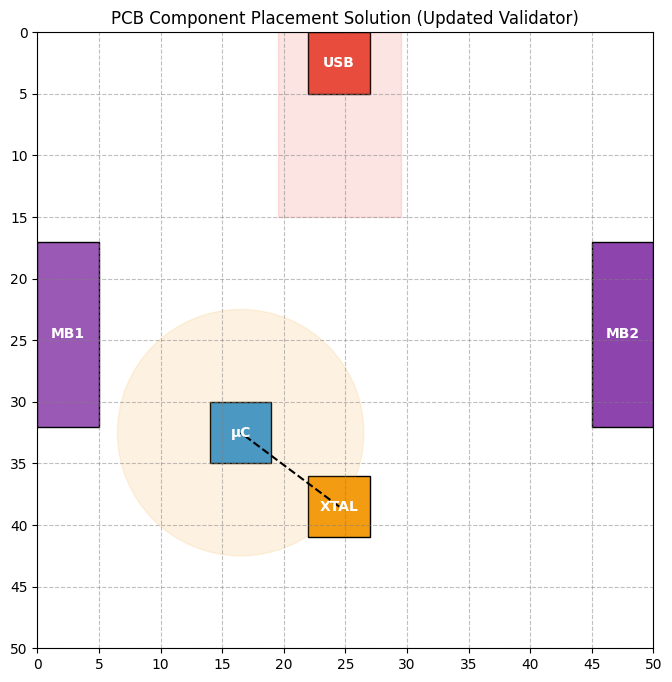

{'USB_CONNECTOR': {'x': 22.0, 'y': 0.0, 'w': 5.0, 'h': 5.0},
 'MIKROBUS_CONNECTOR_1': {'x': 0.0, 'y': 17.0, 'w': 5.0, 'h': 15.0},
 'MIKROBUS_CONNECTOR_2': {'x': 45.0, 'y': 17.0, 'w': 5.0, 'h': 15.0},
 'MICROCONTROLLER': {'x': 14.0, 'y': 30.0, 'w': 5.0, 'h': 5.0},
 'CRYSTAL': {'x': 22.0, 'y': 36.0, 'w': 5.0, 'h': 5.0}}

In [9]:
basic_solver_with_output()


--- Calculating Placement Score (Lower is Better) ---
Compactness Score (Bounding Box Area): 2050.00
Centrality Score (uC dist from center): 11.34
-------------------------------------------
Total Combined Score: 2163.36
-------------------------------------------

--- Calculating Placement Score (Lower is Better) ---
Compactness Score (Bounding Box Area): 1950.00
Centrality Score (uC dist from center): 11.34
-------------------------------------------
Total Combined Score: 2063.36
-------------------------------------------

--- Calculating Placement Score (Lower is Better) ---
Compactness Score (Bounding Box Area): 2000.00
Centrality Score (uC dist from center): 12.02
-------------------------------------------
Total Combined Score: 2120.21
-------------------------------------------

--- Calculating Placement Score (Lower is Better) ---
Compactness Score (Bounding Box Area): 2050.00
Centrality Score (uC dist from center): 12.02
-------------------------------------------
Total Comb

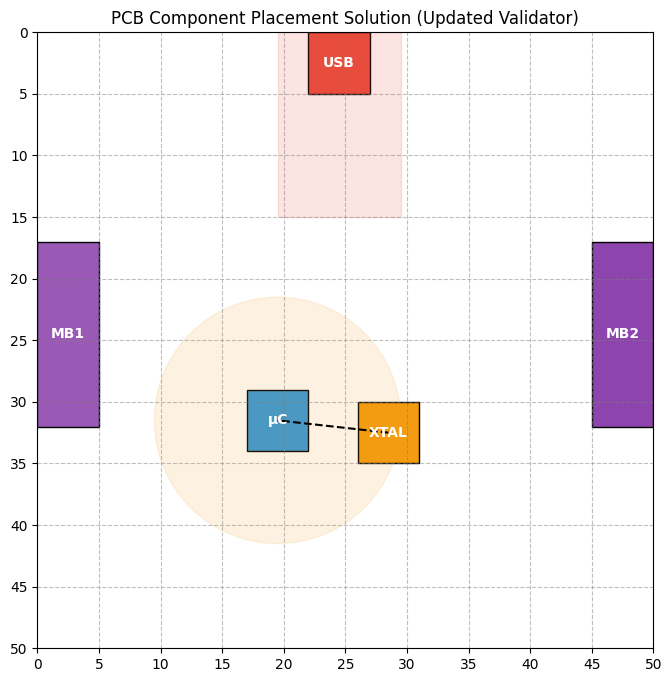

{'USB_CONNECTOR': {'x': 22.0, 'y': 0.0, 'w': 5.0, 'h': 5.0},
 'MIKROBUS_CONNECTOR_1': {'x': 0.0, 'y': 17.0, 'w': 5.0, 'h': 15.0},
 'MIKROBUS_CONNECTOR_2': {'x': 45.0, 'y': 17.0, 'w': 5.0, 'h': 15.0},
 'MICROCONTROLLER': {'x': 17.0, 'y': 29.0, 'w': 5.0, 'h': 5.0},
 'CRYSTAL': {'x': 26.0, 'y': 30.0, 'w': 5.0, 'h': 5.0}}

In [11]:
optimizer() 